## Import lib

In [1]:
from DataSet import DataSet
from SimGPBO import SimGPBO
from PostProcessor import PostProcessor
import GPy
import numpy as np 
import matplotlib.pyplot as plt

## Import data

In [2]:
ds = DataSet('../data/','nhp','Cebus1_M1_190221.mat','first_GPBO_validResponses')
ds.load_matlab_data() # load data from the dataset_file

## Find hyperparameters 

In [ ]:
pp1 = PostProcessor('results/gpbo_NEI_first_GPBO_validResponses_300it.npz')
pp1.load_data()

In [ ]:
print(pp1.P_test_x.shape)
train_X = pp1.P_test_x[:,5]
print(train_X.shape)

(6, 10, 2, 300)
(6, 2, 300)


In [ ]:
print(pp1.P_test_y.shape)
train_Y = pp1.P_test_y[:,5]
print(train_Y.shape)

(6, 10, 1, 300)
(6, 1, 300)


In [ ]:
kernel = GPy.kern.Matern52(input_dim=2,variance=1.0, lengthscale=[1.0, 1.0], ARD=True, name='Mat52') 

In [ ]:
def optimize_gp_hyperparameters(kernel, train_X, train_Y, noise_min=1e-3, noise_max=5.0, max_iters=100):
    """
    Optimise les hyperparamètres d'un modèle GP : longueur d'échelle, variance du noyau, variance du bruit.
    
    Args:
        kernel (GPy.kern.Kern): Le noyau utilisé pour le GP (ex: RBF, Matérn, etc.).
        train_X (np.ndarray): Les données d'entrée pour l'entraînement (n_samples, n_features).
        train_Y (np.ndarray): Les données de sortie correspondantes (n_samples, 1).
        noise_min (float): Borne inférieure pour la variance du bruit.
        noise_max (float): Borne supérieure pour la variance du bruit.
        max_iters (int): Nombre maximum d'itérations pour l'optimisation.
    
    Returns:
        dict: Un dictionnaire contenant les hyperparamètres optimaux :
              - 'lengthscales': Longueurs d'échelle du noyau
              - 'variance': Variance du noyau
              - 'noise_variance': Variance du bruit
    """
    # Créer un modèle GPRegression
    model = GPy.models.GPRegression(train_X, train_Y, kernel=kernel, normalizer=None)
    
    # Contraindre la variance du bruit dans une plage raisonnable
    model.Gaussian_noise.constrain_bounded(noise_min, noise_max, warning=False)
    
    # Optimisation des hyperparamètres
    model.optimize(optimizer='scg', max_iters=max_iters, messages=False)
    
    # Récupération des hyperparamètres optimaux
    lengthscales = model.kern.lengthscale.values if hasattr(model.kern, 'lengthscale') else None
    variance = model.kern.variance.values if hasattr(model.kern, 'variance') else None
    noise_variance = model.Gaussian_noise.variance.values
    
    return {
        "lengthscales": lengthscales,
        "variance": variance,
        "noise_variance": noise_variance
    }

In [ ]:
it = np.arange(100, 500+1, 100)
lengthscales_exp = np.zeros((len(it),6,2))
variance_exp = np.zeros((len(it),6))
noise_variance_exp = np.zeros((len(it),6))

for emg in range(6):
    for i in range(len(it)):
        dic=optimize_gp_hyperparameters(kernel=kernel, train_X=train_X[emg, :, :it[i]].T, train_Y=train_Y[emg, :, :it[i]].T, noise_min=1.e-5, noise_max=5, max_iters=100)
        lengthscales_exp[i,emg,:] = dic["lengthscales"]
        variance_exp[i,emg] = dic["variance"]
        noise_variance_exp[i,emg] = dic["noise_variance"]

In [ ]:
lengthscale_1_exp = lengthscales_exp[:,:,0]
lengthscale_2_exp = lengthscales_exp[:,:,1]
lengthscale_1_exp_m = np.mean(lengthscale_1_exp, axis=1)
lengthscale_2_exp_m = np.mean(lengthscale_2_exp, axis=1)
variance_exp_m = np.mean(variance_exp, axis=1)
noise_variance_exp_m = np.mean(noise_variance_exp, axis=1)

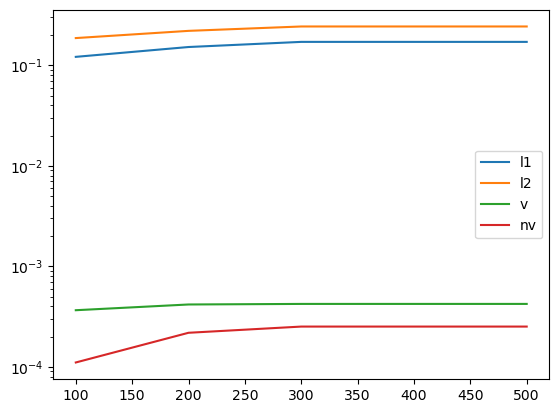

lengthscales:  [0.17098939873531763, 0.24334464463909303] 
variance:  0.0004223094519695253 
noise_variance:  0.00025126325878693426


In [ ]:
plt.plot(it,lengthscale_1_exp_m, label='l1')
plt.plot(it,lengthscale_2_exp_m, label='l2')
plt.plot(it,variance_exp_m, label='v')
plt.plot(it,noise_variance_exp_m, label='nv')
plt.legend()
plt.yscale('log')
plt.show()

hyp = {
        "lengthscales": [lengthscale_1_exp_m[-1], lengthscale_2_exp_m[-1]],
        "variance": variance_exp_m[-1],
        "noise_variance": noise_variance_exp_m[-1]
}

print(
        "lengthscales: ", [lengthscale_1_exp_m[-1], lengthscale_2_exp_m[-1]],
        "\nvariance: ", variance_exp_m[-1],
        "\nnoise_variance: ", noise_variance_exp_m[-1]
)

Cebus 1 - 6 emgs - for 500 queries

lengthscales:  [[0.152, 0.246], [0.172, 0.228], [0.140, 0.225], [0.174, 0.254], [0.180, 0.254], [0.171, 0.243]]

variance:  [0.000355, 0.000405, 0.000392, 0.000395, 0.000368, 0.000422]

noise_variance:  [0.000206, 0.000215, 0.000210, 0.000286, 0.000180, 0.000251] 

## Simulation 

In [18]:
sim_gpbo = SimGPBO(name = 'test_hyp', 
                    ds = ds,
                    AF = 'NEI',
                    NB_REP = 2,
                    NB_IT = 100
                    )

In [3]:
# sim_gpbo.select_emgs([0,1])

In [5]:
# sim_gpbo.set_custom_gp_hyperparameters(kernel_type='Mat52', noise_std=0.0002, output_std=0.0004, lengthscale=[0.16, 0.24])

In [19]:
sim_gpbo.run_simulations(gp_origin='gpytorch', hyperparams_storage=True)

Global Progress: 100%|██████████| 12/12 [03:49<00:00, 19.15s/iter]

Elapsed time: 229.8044228553772 seconds
final save of test_hyp in:   results/gpbo_gpytorch_NEI_first_GPBO_validResponses_test_hyp.npz


In [17]:
sim_gpbo.gp.likelihood.noise

tensor([0.1500, 0.1500, 0.1500, 0.1500, 0.1500, 0.1500, 0.1500, 0.1500, 0.1500,
        0.1500, 0.1500, 0.1500, 0.1500, 0.1500, 0.1500, 0.1500, 0.1500, 0.1500,
        0.1500, 0.1500, 0.1500, 0.1500, 0.1500, 0.1500, 0.1500, 0.1500, 0.1500,
        0.1500, 0.1500, 0.1500, 0.1500, 0.1500, 0.1500, 0.1500, 0.1500, 0.1500,
        0.1500, 0.1500, 0.1500, 0.1500, 0.1500, 0.1500, 0.1500, 0.1500, 0.1500,
        0.1500, 0.1500, 0.1500, 0.1500, 0.1500, 0.1500, 0.1500, 0.1500, 0.1500,
        0.1500, 0.1500, 0.1500, 0.1500, 0.1500, 0.1500, 0.1500, 0.1500],
       dtype=torch.float64)

In [9]:
sim_gpbo.gp.covar_module.lengthscale

Parameter containing:
tensor([[0.1267, 0.1225]], dtype=torch.float64, requires_grad=True)

In [8]:
print(sim_gpbo.gp.covar_module)

RBFKernel(
  (lengthscale_prior): LogNormalPrior()
  (raw_lengthscale_constraint): GreaterThan(2.500E-02)
)


In [20]:
print(sim_gpbo.hyperparams_noise_std)

tensor([[[[0.3873, 0.3873, 0.3873,  ..., 0.3873, 0.3873, 0.3873]],

         [[0.3873, 0.3873, 0.3873,  ..., 0.3873, 0.3873, 0.3873]]],


        [[[0.3873, 0.3873, 0.3873,  ..., 0.3873, 0.3873, 0.3873]],

         [[0.3873, 0.3873, 0.3873,  ..., 0.3873, 0.3873, 0.3873]]],


        [[[0.3873, 0.3873, 0.3873,  ..., 0.3873, 0.3873, 0.3873]],

         [[0.3873, 0.3873, 0.3873,  ..., 0.3873, 0.3873, 0.3873]]],


        [[[0.3873, 0.3873, 0.3873,  ..., 0.3873, 0.3873, 0.3873]],

         [[0.3873, 0.3873, 0.3873,  ..., 0.3873, 0.3873, 0.3873]]],


        [[[0.3873, 0.3873, 0.3873,  ..., 0.3873, 0.3873, 0.3873]],

         [[0.3873, 0.3873, 0.3873,  ..., 0.3873, 0.3873, 0.3873]]],


        [[[0.3873, 0.3873, 0.3873,  ..., 0.3873, 0.3873, 0.3873]],

         [[0.3873, 0.3873, 0.3873,  ..., 0.3873, 0.3873, 0.3873]]]],
       dtype=torch.float64)


In [33]:
noise_std = np.mean(sim_gpbo.hyperparams_noise_std.numpy(), axis=(0,1,2))
print(noise_std)

[0.38729833 0.38729833 0.38729833 0.38729833 0.38729833 0.38729833
 0.38729833 0.38729833 0.38729833 0.38729833 0.38729833 0.38729833
 0.38729833 0.38729833 0.38729833 0.38729833 0.38729833 0.38729833
 0.38729833 0.38729833 0.38729833 0.38729833 0.38729833 0.38729833
 0.38729833 0.38729833 0.38729833 0.38729833 0.38729833 0.38729833
 0.38729833 0.38729833 0.38729833 0.38729833 0.38729833 0.38729833
 0.38729833 0.38729833 0.38729833 0.38729833 0.38729833 0.38729833
 0.38729833 0.38729833 0.38729833 0.38729833 0.38729833 0.38729833
 0.38729833 0.38729833 0.38729833 0.38729833 0.38729833 0.38729833
 0.38729833 0.38729833 0.38729833 0.38729833 0.38729833 0.38729833
 0.38729833 0.38729833 0.38729833 0.38729833 0.38729833 0.38729833
 0.38729833 0.38729833 0.38729833 0.38729833 0.38729833 0.38729833
 0.38729833 0.38729833 0.38729833 0.38729833 0.38729833 0.38729833
 0.38729833 0.38729833 0.38729833 0.38729833 0.38729833 0.38729833
 0.38729833 0.38729833 0.38729833 0.38729833 0.38729833 0.3872

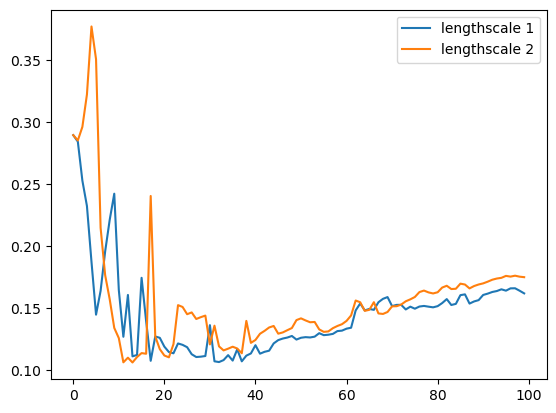

In [37]:
l1 = np.mean(sim_gpbo.hyperparams_l1.numpy(), axis=(0,1,2))
l2 = np.mean(sim_gpbo.hyperparams_l2.numpy(), axis=(0,1,2))

plt.plot(l1, label='lengthscale 1')
plt.plot(l2, label='lengthscale 2')
plt.legend()
plt.show()